# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


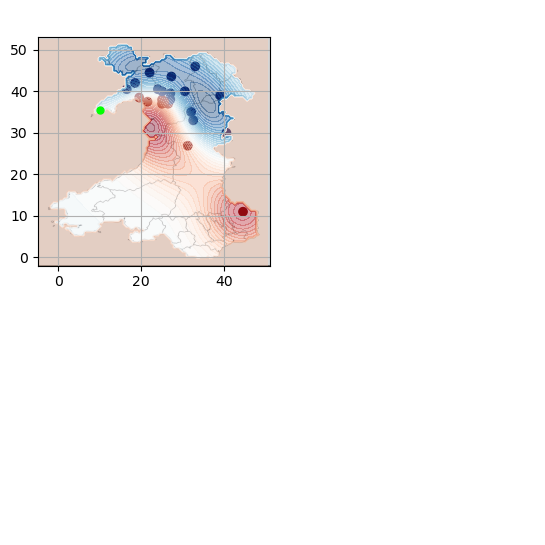

iteration  1
Accuracy is 0.5779657758123438
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.8065756585272063
iteration  4
Accuracy is 0.7340895981542012
iteration  5
Accuracy is 0.5804652951355509
iteration  6
Accuracy is 0.6193039800038455
iteration  7
Accuracy is 0.8175350894058835
iteration  8
Accuracy is 0.7763891559315517
iteration  9
Accuracy is 0.7288982887906172
iteration  10
Accuracy is 0.7988848298404153
iteration  11
Accuracy is 0.7669678907902326
iteration  12
Accuracy is 0.8167660065372044
iteration  13
Accuracy is 0.7723514708709863
iteration  14
Accuracy is 0.7537012113055181
iteration  15
Accuracy is 0.7415881561238223
iteration  16
Accuracy is 0.6904441453566622
iteration  17
Accuracy is 0.7458181119015574
iteration  18
Accuracy is 0.7087098634877909
iteration  19
Accuracy is 0.775235531628533
iteration  20
Accuracy is 0.748702172659104
iteration  21
Accuracy is 0.7692751393962699
experiment:  1


<IPython.core.display.Javascript object>


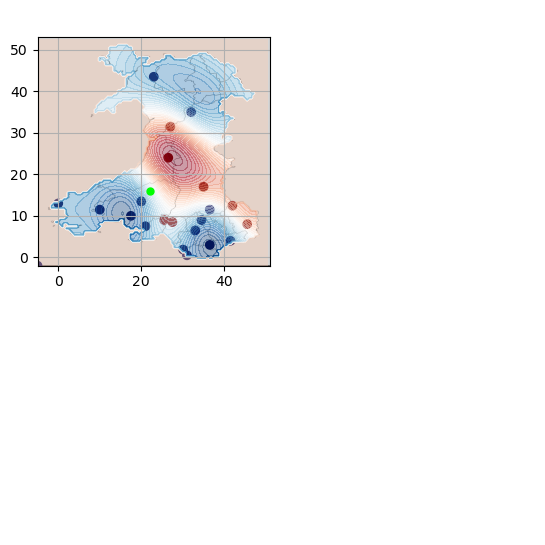

iteration  1
Accuracy is 0.505095174004999
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.6783310901749664
iteration  4
Accuracy is 0.7302441838108056
iteration  5
Accuracy is 0.7215920015381657
iteration  6
Accuracy is 0.6731397808113824
iteration  7
Accuracy is 0.8283022495673908
iteration  8
Accuracy is 0.8338781003653144
iteration  9
Accuracy is 0.8546433378196501
iteration  10
Accuracy is 0.8227263987694674
iteration  11
Accuracy is 0.7958084983656989
iteration  12
Accuracy is 0.7338973274370313
iteration  13
Accuracy is 0.8302249567390886
iteration  14
Accuracy is 0.788117669678908
iteration  15
Accuracy is 0.7131320899826956
iteration  16
Accuracy is 0.6962122668717554
iteration  17
Accuracy is 0.7362045760430687
iteration  18
Accuracy is 0.8275331666987118
iteration  19
Accuracy is 0.7621611228609882
iteration  20
Accuracy is 0.7187079407806191
iteration  21
Accuracy is 0.8029225149009805
experiment:  2


<IPython.core.display.Javascript object>


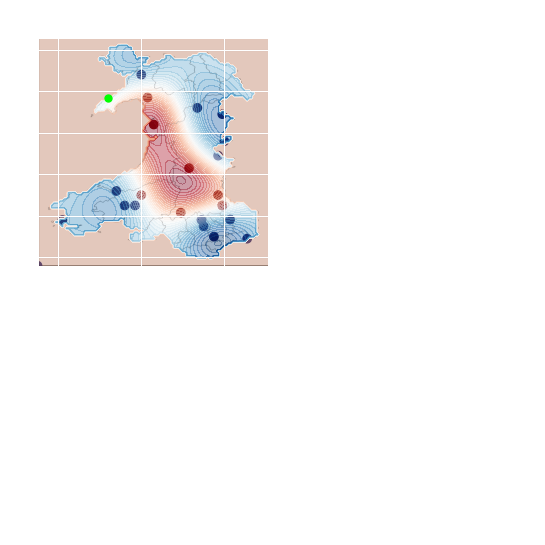

iteration  1
Accuracy is 0.4443376273793501
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.6879446260334551
iteration  4
Accuracy is 0.7206306479523169
iteration  5
Accuracy is 0.7148625264372236
iteration  6
Accuracy is 0.6915977696596808
iteration  7
Accuracy is 0.6629494328013843
iteration  8
Accuracy is 0.6150740242261103
iteration  9
Accuracy is 0.7631224764468372
iteration  10
Accuracy is 0.748702172659104
iteration  11
Accuracy is 0.8079215535473947
iteration  12
Accuracy is 0.7996539127090944
iteration  13
Accuracy is 0.8934820226879446
iteration  14
Accuracy is 0.8688713708902134
iteration  15
Accuracy is 0.8750240338396462
iteration  16
Accuracy is 0.8523360892136128
iteration  17
Accuracy is 0.8204191501634301
iteration  18
Accuracy is 0.804268409921169
iteration  19
Accuracy is 0.8413766583349356
iteration  20
Accuracy is 0.7973466641030571
iteration  21
Accuracy is 0.8467602384156893
experiment:  3


<IPython.core.display.Javascript object>


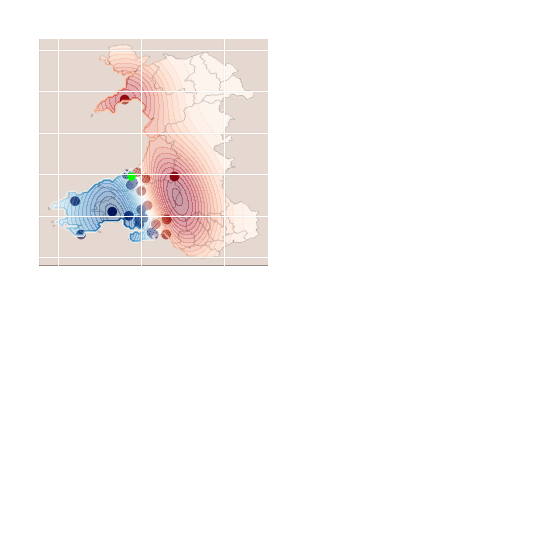

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.6558354162661026
iteration  3
Accuracy is 0.6652566814074217
iteration  4
Accuracy is 0.6506441069025187
iteration  5
Accuracy is 0.7285137473562776
iteration  6
Accuracy is 0.7477408190732552
iteration  7
Accuracy is 0.7833109017496636
iteration  8
Accuracy is 0.765814266487214
iteration  9
Accuracy is 0.7819650067294751
iteration  10
Accuracy is 0.7719669294366468
iteration  11
Accuracy is 0.7865795039415497
iteration  12
Accuracy is 0.8123437800422996
iteration  13
Accuracy is 0.7960007690828687
iteration  14
Accuracy is 0.7002499519323208
iteration  15
Accuracy is 0.706787156316093
iteration  16
Accuracy is 0.7792732166890982
iteration  17
Accuracy is 0.7596616035377812
iteration  18
Accuracy is 0.6975581618919439
iteration  19
Accuracy is 0.7940780619111709
iteration  20
Accuracy is 0.7802345702749471
iteration  21
Accuracy is 0.6608344549125168
experiment:  4


<IPython.core.display.Javascript object>


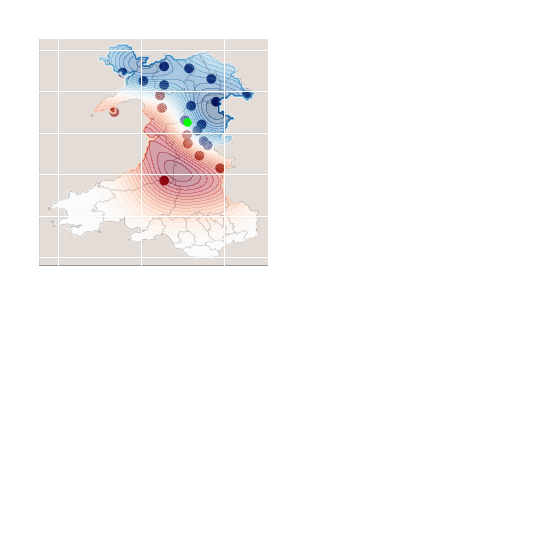

iteration  1
Accuracy is 0.6198807921553547
iteration  2
Accuracy is 0.7365891174774082
iteration  3
Accuracy is 0.660642184195347
iteration  4
Accuracy is 0.6150740242261103
iteration  5
Accuracy is 0.7546625648913671
iteration  6
Accuracy is 0.8015766198807922
iteration  7
Accuracy is 0.7961930398000384
iteration  8
Accuracy is 0.748702172659104
iteration  9
Accuracy is 0.8317631224764468
iteration  10
Accuracy is 0.8117669678907903
iteration  11
Accuracy is 0.8381080561430494
iteration  12
Accuracy is 0.84618342626418
iteration  13
Accuracy is 0.833301288213805
iteration  14
Accuracy is 0.8346471832339935
iteration  15
Accuracy is 0.831570851759277
iteration  16
Accuracy is 0.8340703710824842
iteration  17
Accuracy is 0.8600269179004038
iteration  18
Accuracy is 0.8507979234762546
iteration  19
Accuracy is 0.8336858296481446
iteration  20
Accuracy is 0.8263795423956931
iteration  21
Accuracy is 0.8342626417996539
experiment:  5


<IPython.core.display.Javascript object>


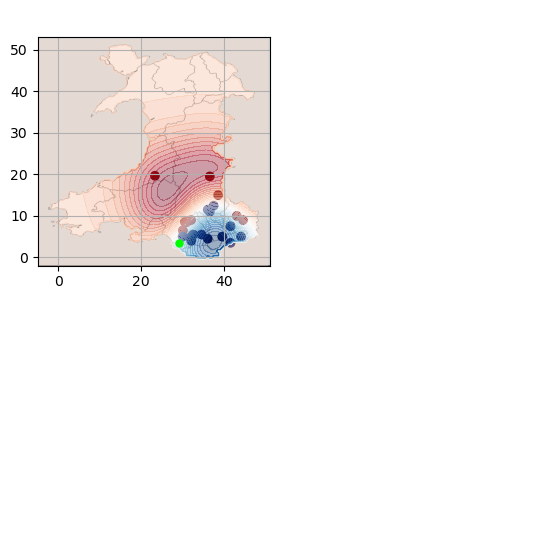

iteration  1
Accuracy is 0.40626802537973467
iteration  2
Accuracy is 0.7108248413766584
iteration  3
Accuracy is 0.4158815612382234
iteration  4
Accuracy is 0.4391463180157662
iteration  5
Accuracy is 0.443568544510671
iteration  6
Accuracy is 0.44856758315708517
iteration  7
Accuracy is 0.4420303787733128
iteration  8
Accuracy is 0.46567967698519513
iteration  9
Accuracy is 0.45798884829840414
iteration  10
Accuracy is 0.4197269755816189
iteration  11
Accuracy is 0.4383772351470871
iteration  12
Accuracy is 0.42799461641991926
iteration  13
Accuracy is 0.45702749471255527
iteration  14
Accuracy is 0.4329936550663334
iteration  15
Accuracy is 0.46279561622764853
iteration  16
Accuracy is 0.45875793116708324
iteration  17
Accuracy is 0.45337435108632956
iteration  18
Accuracy is 0.46356469909632764
iteration  19
Accuracy is 0.4491443953085945
iteration  20
Accuracy is 0.4701019034801
iteration  21
Accuracy is 0.45625841184387617
experiment:  6


<IPython.core.display.Javascript object>


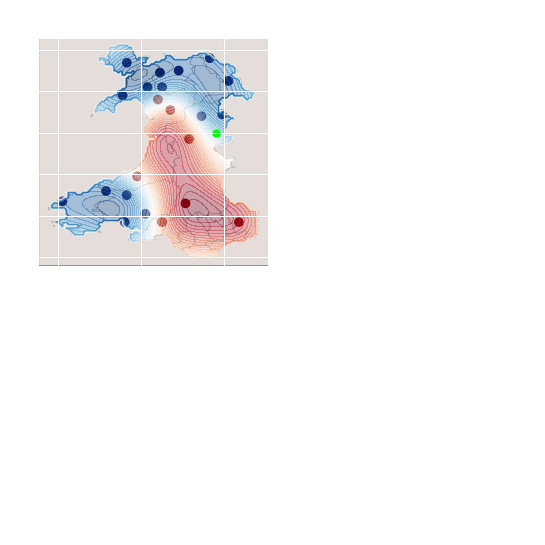

iteration  1
Accuracy is 0.5696981349740434
iteration  2
Accuracy is 0.7210151893866564
iteration  3
Accuracy is 0.4962507210151894
iteration  4
Accuracy is 0.4962507210151894
iteration  5
Accuracy is 0.6940972889828879
iteration  6
Accuracy is 0.7750432609113632
iteration  7
Accuracy is 0.6819842338011921
iteration  8
Accuracy is 0.7681215150932513
iteration  9
Accuracy is 0.802537973466641
iteration  10
Accuracy is 0.8109978850221111
iteration  11
Accuracy is 0.7685060565275909
iteration  12
Accuracy is 0.7083253220534512
iteration  13
Accuracy is 0.7783118631032494
iteration  14
Accuracy is 0.7971543933858873
iteration  15
Accuracy is 0.8094597192847529
iteration  16
Accuracy is 0.7808113824264564
iteration  17
Accuracy is 0.7894635646990963
iteration  18
Accuracy is 0.7635070178811767
iteration  19
Accuracy is 0.715439338588733
iteration  20
Accuracy is 0.7808113824264564
iteration  21
Accuracy is 0.7988848298404153
experiment:  7


<IPython.core.display.Javascript object>


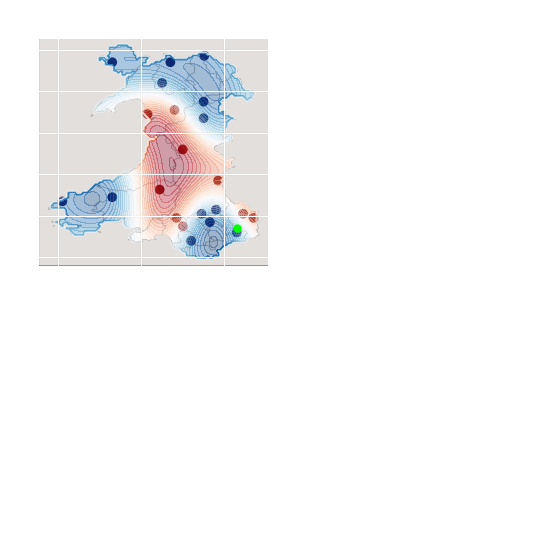

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.7571620842145741
iteration  3
Accuracy is 0.7263987694674101
iteration  4
Accuracy is 0.7027494712555278
iteration  5
Accuracy is 0.6637185156700635
iteration  6
Accuracy is 0.6154585656604499
iteration  7
Accuracy is 0.7165929628917516
iteration  8
Accuracy is 0.821380503749279
iteration  9
Accuracy is 0.8063833878100365
iteration  10
Accuracy is 0.8492597577388964
iteration  11
Accuracy is 0.8425302826379543
iteration  12
Accuracy is 0.8646414151124784
iteration  13
Accuracy is 0.8805998846375697
iteration  14
Accuracy is 0.892328398384926
iteration  15
Accuracy is 0.8713708902134205
iteration  16
Accuracy is 0.8457988848298404
iteration  17
Accuracy is 0.8406075754662565
iteration  18
Accuracy is 0.8542587963853105
iteration  19
Accuracy is 0.8584887521630455
iteration  20
Accuracy is 0.8869448183041723
iteration  21
Accuracy is 0.8838684868294558
experiment:  8


<IPython.core.display.Javascript object>


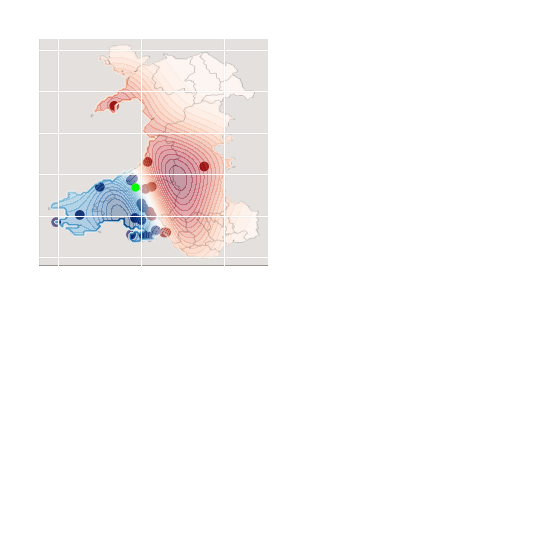

iteration  1
Accuracy is 0.5514324168429148
iteration  2
Accuracy is 0.706787156316093
iteration  3
Accuracy is 0.6627571620842145
iteration  4
Accuracy is 0.46318015766198806
iteration  5
Accuracy is 0.5354739473178235
iteration  6
Accuracy is 0.5314362622572583
iteration  7
Accuracy is 0.4858681022880215
iteration  8
Accuracy is 0.6233416650644107
iteration  9
Accuracy is 0.5074024226110363
iteration  10
Accuracy is 0.5045183618534897
iteration  11
Accuracy is 0.5306671793885791
iteration  12
Accuracy is 0.5458565660449913
iteration  13
Accuracy is 0.5448952124591425
iteration  14
Accuracy is 0.5460488367621611
iteration  15
Accuracy is 0.5248990578734859
iteration  16
Accuracy is 0.5550855604691406
iteration  17
Accuracy is 0.5477792732166891
iteration  18
Accuracy is 0.5473947317823495
iteration  19
Accuracy is 0.5966160353778119
iteration  20
Accuracy is 0.5377811959238608
iteration  21
Accuracy is 0.5483560853681985
experiment:  9


<IPython.core.display.Javascript object>


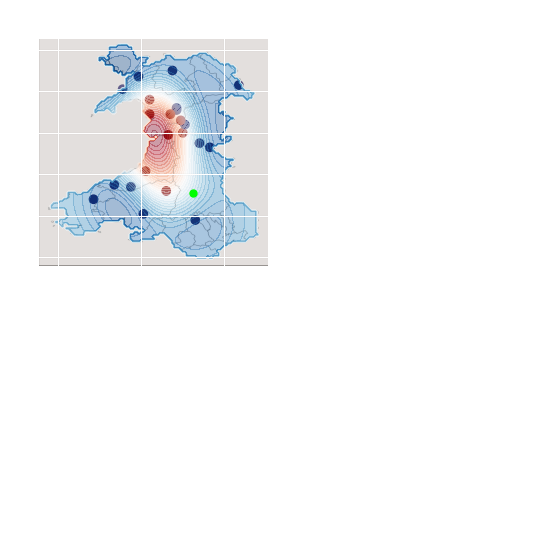

iteration  1
Accuracy is 0.5945010574889444
iteration  2
Accuracy is 0.7142857142857143
iteration  3
Accuracy is 0.6725629686598731
iteration  4
Accuracy is 0.6589117477408191
iteration  5
Accuracy is 0.648721399730821
iteration  6
Accuracy is 0.6150740242261103
iteration  7
Accuracy is 0.7206306479523169
iteration  8
Accuracy is 0.6917900403768507
iteration  9
Accuracy is 0.7433185925783503
iteration  10
Accuracy is 0.719669294366468
iteration  11
Accuracy is 0.758123437800423
iteration  12
Accuracy is 0.7390886368006153
iteration  13
Accuracy is 0.7177465871947702
iteration  14
Accuracy is 0.7356277638915593
iteration  15
Accuracy is 0.7650451836185349
iteration  16
Accuracy is 0.746202653335897
iteration  17
Accuracy is 0.7463949240530667
iteration  18
Accuracy is 0.7692751393962699
iteration  19
Accuracy is 0.7619688521438185
iteration  20
Accuracy is 0.7844645260526821
iteration  21
Accuracy is 0.7719669294366468
experiment:  10


<IPython.core.display.Javascript object>


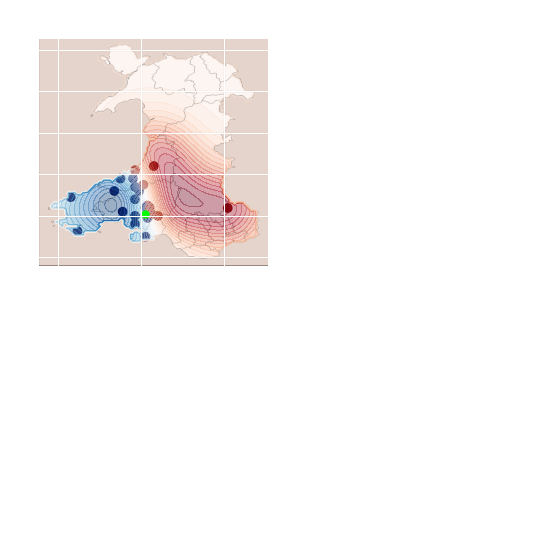

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.6321861180542203
iteration  3
Accuracy is 0.6177658142664872
iteration  4
Accuracy is 0.6877523553162853
iteration  5
Accuracy is 0.7014035762353393
iteration  6
Accuracy is 0.6527590847913862
iteration  7
Accuracy is 0.5454720246106518
iteration  8
Accuracy is 0.73505095174005
iteration  9
Accuracy is 0.7796577581234378
iteration  10
Accuracy is 0.5337435108632955
iteration  11
Accuracy is 0.7667756200730629
iteration  12
Accuracy is 0.5418188809844261
iteration  13
Accuracy is 0.7844645260526821
iteration  14
Accuracy is 0.7840799846183426
iteration  15
Accuracy is 0.7761968852143819
iteration  16
Accuracy is 0.7815804652951356
iteration  17
Accuracy is 0.7790809459719285
iteration  18
Accuracy is 0.7779273216689099
iteration  19
Accuracy is 0.7992693712747548
iteration  20
Accuracy is 0.7948471447798501
iteration  21
Accuracy is 0.7921553547394732
experiment:  11


<IPython.core.display.Javascript object>


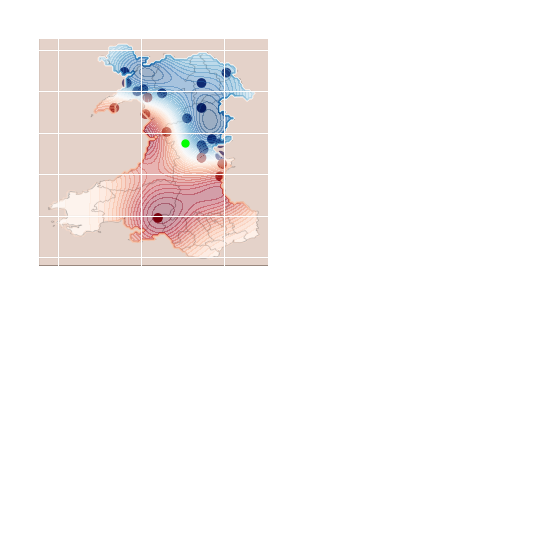

iteration  1
Accuracy is 0.48202268794462605
iteration  2
Accuracy is 0.6962122668717554
iteration  3
Accuracy is 0.6664103057104404
iteration  4
Accuracy is 0.7283214766391078
iteration  5
Accuracy is 0.7131320899826956
iteration  6
Accuracy is 0.7594693328206115
iteration  7
Accuracy is 0.7387040953662757
iteration  8
Accuracy is 0.7035185541242068
iteration  9
Accuracy is 0.7142857142857143
iteration  10
Accuracy is 0.6689098250336474
iteration  11
Accuracy is 0.6648721399730821
iteration  12
Accuracy is 0.6831378581042107
iteration  13
Accuracy is 0.6842914824072294
iteration  14
Accuracy is 0.6673716592962892
iteration  15
Accuracy is 0.6783310901749664
iteration  16
Accuracy is 0.6725629686598731
iteration  17
Accuracy is 0.6544895212459142
iteration  18
Accuracy is 0.7133243606998654
iteration  19
Accuracy is 0.7200538358008075
iteration  20
Accuracy is 0.7300519130936358
iteration  21
Accuracy is 0.7073639684676024
experiment:  12


<IPython.core.display.Javascript object>


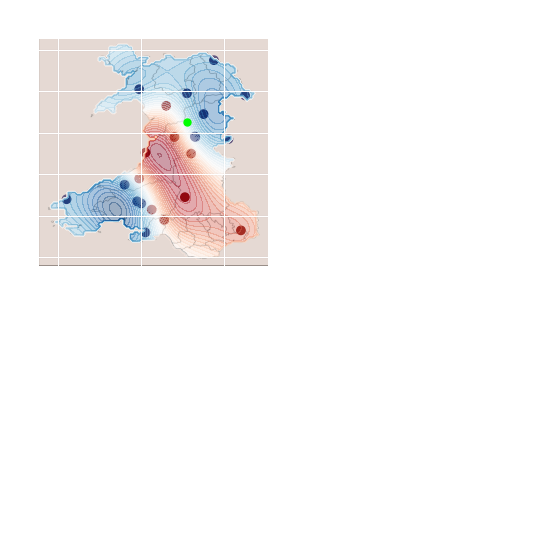

iteration  1
Accuracy is 0.5556623726206499
iteration  2
Accuracy is 0.6679484714477985
iteration  3
Accuracy is 0.6508363776196885
iteration  4
Accuracy is 0.6314170351855413
iteration  5
Accuracy is 0.6150740242261103
iteration  6
Accuracy is 0.6583349355893098
iteration  7
Accuracy is 0.7100557585079792
iteration  8
Accuracy is 0.8067679292443761
iteration  9
Accuracy is 0.7971543933858873
iteration  10
Accuracy is 0.8127283214766391
iteration  11
Accuracy is 0.8006152662949433
iteration  12
Accuracy is 0.8117669678907903
iteration  13
Accuracy is 0.8069601999615459
iteration  14
Accuracy is 0.7956162276485291
iteration  15
Accuracy is 0.8106133435877716
iteration  16
Accuracy is 0.7785041338204192
iteration  17
Accuracy is 0.7890790232647568
iteration  18
Accuracy is 0.7821572774466449
iteration  19
Accuracy is 0.8200346087290905
iteration  20
Accuracy is 0.8038838684868295
iteration  21
Accuracy is 0.8083060949817343
experiment:  13


<IPython.core.display.Javascript object>


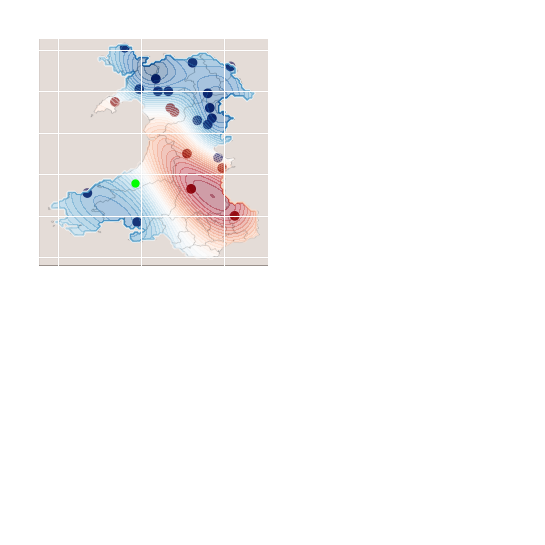

iteration  1
Accuracy is 0.5716208421457412
iteration  2
Accuracy is 0.6035377811959238
iteration  3
Accuracy is 0.6164199192462988
iteration  4
Accuracy is 0.5766198807921553
iteration  5
Accuracy is 0.5833493558930974
iteration  6
Accuracy is 0.5831570851759277
iteration  7
Accuracy is 0.6031532397615843
iteration  8
Accuracy is 0.819650067294751
iteration  9
Accuracy is 0.817919630840223
iteration  10
Accuracy is 0.7729282830224957
iteration  11
Accuracy is 0.8173428186887137
iteration  12
Accuracy is 0.790617189002115
iteration  13
Accuracy is 0.7663910786387234
iteration  14
Accuracy is 0.7379350124975966
iteration  15
Accuracy is 0.6944818304172274
iteration  16
Accuracy is 0.8123437800422996
iteration  17
Accuracy is 0.8184964429917324
iteration  18
Accuracy is 0.8096519900019227
iteration  19
Accuracy is 0.804268409921169
iteration  20
Accuracy is 0.7911940011536243
iteration  21
Accuracy is 0.7917708133051337
experiment:  14


<IPython.core.display.Javascript object>


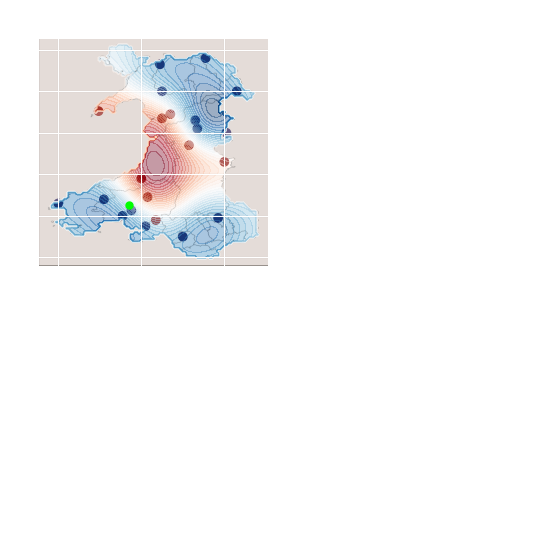

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.6979427033262834
iteration  4
Accuracy is 0.6664103057104404
iteration  5
Accuracy is 0.6492982118823303
iteration  6
Accuracy is 0.6929436646798692
iteration  7
Accuracy is 0.7096712170736397
iteration  8
Accuracy is 0.7115939242453374
iteration  9
Accuracy is 0.7035185541242068
iteration  10
Accuracy is 0.6927513939626995
iteration  11
Accuracy is 0.6706402614881753
iteration  12
Accuracy is 0.7262064987502403
iteration  13
Accuracy is 0.7967698519515478
iteration  14
Accuracy is 0.8254181888098443
iteration  15
Accuracy is 0.8400307633147471
iteration  16
Accuracy is 0.8336858296481446
iteration  17
Accuracy is 0.8400307633147471
iteration  18
Accuracy is 0.8352239953855027
iteration  19
Accuracy is 0.813689675062488
iteration  20
Accuracy is 0.805998846375697
iteration  21
Accuracy is 0.8344549125168237
experiment:  15


<IPython.core.display.Javascript object>


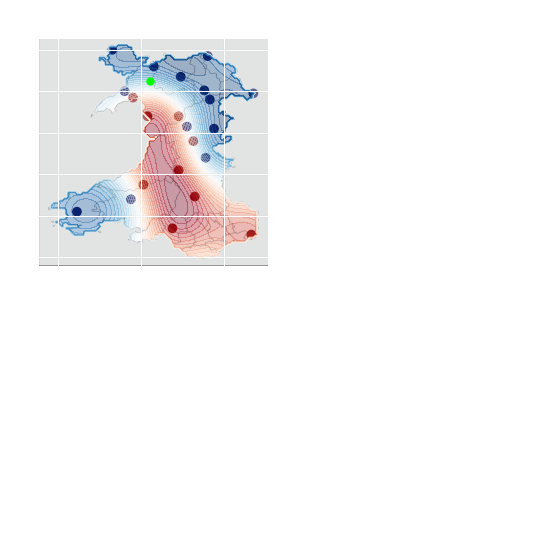

iteration  1
Accuracy is 0.6021918861757354
iteration  2
Accuracy is 0.7485099019419342
iteration  3
Accuracy is 0.5343203230148048
iteration  4
Accuracy is 0.5737358200346088
iteration  5
Accuracy is 0.7833109017496636
iteration  6
Accuracy is 0.8208036915977697
iteration  7
Accuracy is 0.7800422995577774
iteration  8
Accuracy is 0.6852528359930783
iteration  9
Accuracy is 0.6512209190540281
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6150740242261103
iteration  12
Accuracy is 0.635070178811767
iteration  13
Accuracy is 0.6808306094981734
iteration  14
Accuracy is 0.6960199961545857
iteration  15
Accuracy is 0.6915977696596808
iteration  16
Accuracy is 0.730820995962315
iteration  17
Accuracy is 0.730820995962315
iteration  18
Accuracy is 0.7813881945779658
iteration  19
Accuracy is 0.8069601999615459
iteration  20
Accuracy is 0.813689675062488
iteration  21
Accuracy is 0.8165737358200346
experiment:  16


<IPython.core.display.Javascript object>


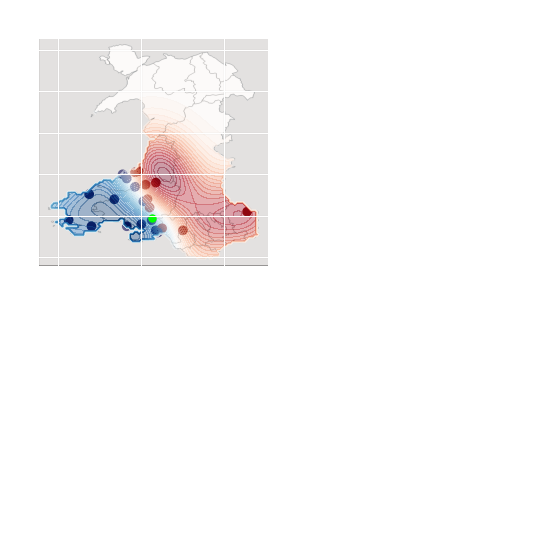

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.706018073447414
iteration  3
Accuracy is 0.6539127090944049
iteration  4
Accuracy is 0.5287444722168814
iteration  5
Accuracy is 0.7285137473562776
iteration  6
Accuracy is 0.7108248413766584
iteration  7
Accuracy is 0.5868102288021534
iteration  8
Accuracy is 0.6168044606806383
iteration  9
Accuracy is 0.7281292059219381
iteration  10
Accuracy is 0.6662180349932705
iteration  11
Accuracy is 0.6023841568929053
iteration  12
Accuracy is 0.746202653335897
iteration  13
Accuracy is 0.519707748509902
iteration  14
Accuracy is 0.5466256489136705
iteration  15
Accuracy is 0.5448952124591425
iteration  16
Accuracy is 0.5289367429340511
iteration  17
Accuracy is 0.7636992885983465
iteration  18
Accuracy is 0.7538934820226879
iteration  19
Accuracy is 0.7727360123053258
iteration  20
Accuracy is 0.7248606037300519
iteration  21
Accuracy is 0.5423956931359354
experiment:  17


<IPython.core.display.Javascript object>


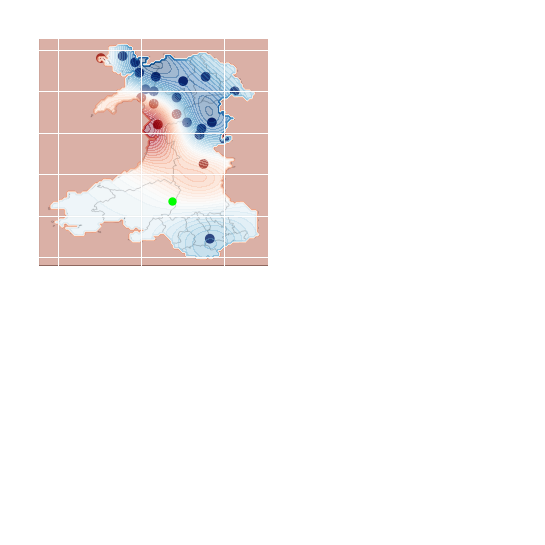

iteration  1
Accuracy is 0.49701980388386846
iteration  2
Accuracy is 0.593155162468756
iteration  3
Accuracy is 0.5593155162468756
iteration  4
Accuracy is 0.5635454720246107
iteration  5
Accuracy is 0.73505095174005
iteration  6
Accuracy is 0.6789079023264757
iteration  7
Accuracy is 0.6244952893674294
iteration  8
Accuracy is 0.8146510286483368
iteration  9
Accuracy is 0.629878869448183
iteration  10
Accuracy is 0.6254566429532782
iteration  11
Accuracy is 0.8167660065372044
iteration  12
Accuracy is 0.8056143049413574
iteration  13
Accuracy is 0.7729282830224957
iteration  14
Accuracy is 0.8371467025572006
iteration  15
Accuracy is 0.8233032109209767
iteration  16
Accuracy is 0.789655835416266
iteration  17
Accuracy is 0.856373774274178
iteration  18
Accuracy is 0.8484906748702172
iteration  19
Accuracy is 0.779465487406268
iteration  20
Accuracy is 0.6710248029225149
iteration  21
Accuracy is 0.6585272063064795
experiment:  18


<IPython.core.display.Javascript object>


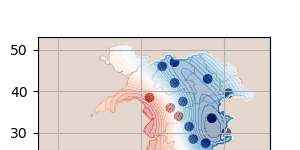

iteration  1
Accuracy is 0.39030955585464333
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.5318208036915978
iteration  4
Accuracy is 0.7400499903864641
iteration  5
Accuracy is 0.5314362622572583
iteration  6
Accuracy is 0.5652759084791387
iteration  7
Accuracy is 0.6273793501249759
iteration  8
Accuracy is 0.717169775043261
iteration  9
Accuracy is 0.6965968083060949
iteration  10
Accuracy is 0.7046721784272255
iteration  11
Accuracy is 0.6448759853874255
iteration  12
Accuracy is 0.5989232839838493
iteration  13
Accuracy is 0.6300711401653528
iteration  14
Accuracy is 0.6266102672562969
iteration  15
Accuracy is 0.6268025379734666
iteration  16
Accuracy is 0.6314170351855413
iteration  17
Accuracy is 0.6569890405691213
iteration  18
Accuracy is 0.6110363391655451
iteration  19
Accuracy is 0.5993078254181888
iteration  20
Accuracy is 0.6194962507210152
iteration  21
Accuracy is 0.6335320130744088
experiment:  19


<IPython.core.display.Javascript object>


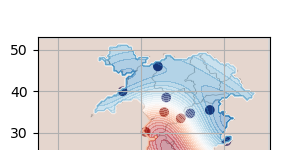

iteration  1
Accuracy is 0.5673908863680062
iteration  2
Accuracy is 0.38492597577388965
iteration  3
Accuracy is 0.7160161507402423
iteration  4
Accuracy is 0.7365891174774082
iteration  5
Accuracy is 0.6981349740434531
iteration  6
Accuracy is 0.6708325322053451
iteration  7
Accuracy is 0.6508363776196885
iteration  8
Accuracy is 0.8100365314362623
iteration  9
Accuracy is 0.7833109017496636
iteration  10
Accuracy is 0.8319553931936167
iteration  11
Accuracy is 0.8177273601230532
iteration  12
Accuracy is 0.8384925975773889
iteration  13
Accuracy is 0.8415689290521053
iteration  14
Accuracy is 0.8494520284560662
iteration  15
Accuracy is 0.8298404153047491
iteration  16
Accuracy is 0.8098442607190924
iteration  17
Accuracy is 0.8546433378196501
iteration  18
Accuracy is 0.8356085368198424
iteration  19
Accuracy is 0.8644491443953086
iteration  20
Accuracy is 0.8584887521630455
iteration  21
Accuracy is 0.8638723322437992
experiment:  20


<IPython.core.display.Javascript object>


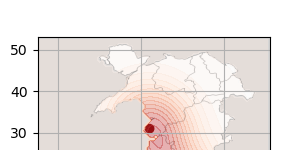

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.7117861949625072
iteration  3
Accuracy is 0.6739088636800615
iteration  4
Accuracy is 0.5260526821765045
iteration  5
Accuracy is 0.5072101518938665
iteration  6
Accuracy is 0.5456642953278216
iteration  7
Accuracy is 0.548740626802538
iteration  8
Accuracy is 0.5746971736204576
iteration  9
Accuracy is 0.7240915208613729
iteration  10
Accuracy is 0.665833493558931
iteration  11
Accuracy is 0.6792924437608152
iteration  12
Accuracy is 0.7417804268409921
iteration  13
Accuracy is 0.7096712170736397
iteration  14
Accuracy is 0.7142857142857143
iteration  15
Accuracy is 0.7287060180734474
iteration  16
Accuracy is 0.7212074601038262
iteration  17
Accuracy is 0.7164006921745818
iteration  18
Accuracy is 0.7229378965583542
iteration  19
Accuracy is 0.681215150932513
iteration  20
Accuracy is 0.7423572389925014
iteration  21
Accuracy is 0.6902518746394924


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 74.24 %
Improvement is = 17.69 %


In [11]:
np.savetxt('branin05rbf', Results)